In [1]:
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mxnet import nd


from NeuralNet import NeuralNet
from SymNet import SymNet
from Layer import Layer
from test_function import triangle
from activation import echelon, echelonSmooth

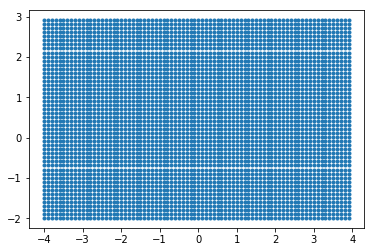

In [2]:
def generate_grid_test(limit, step = 10):
    Y_tmp = [x/step + 0.01 for x in range(-2*step,3*step, 1)] # +0.01 pour ne pas tomber pile sur la frontiere (pas terrible a l'affichage)
    n = len(Y_tmp)
    input_test = nd.zeros((2, n * 20 * limit))
    input_test[0] = nd.arange(-limit,limit,0.1,n)
    input_test[1] = nd.array(Y_tmp*20*limit)
    return input_test

input_test = generate_grid_test(4)
plt.plot(input_test[0].asnumpy(), input_test[1].asnumpy(), '.')
plt.show()

In [4]:
limit = 2
sample_size = limit * 100000

input_train = nd.zeros((2, sample_size))
input_train[0] = nd.random.uniform(-limit, limit, sample_size)
input_train[1] = nd.random.uniform(-0.1,1.1, sample_size)
input_test = nd.zeros((2, sample_size))
input_test[0] = nd.random.uniform(-limit, limit, sample_size)
input_test[1] = nd.random.uniform(-1,2, sample_size)

input_grid = generate_grid_test(2*limit)

output_train = triangle(input_train)
output_test = triangle(input_test)
output_grid = triangle(input_grid)

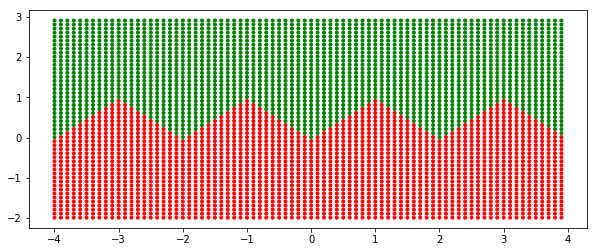

In [5]:
def plot2D(_input, output, title = ""):
    colors = ['red','green']
    plt.title(title)
    plt.scatter(_input[0].asnumpy(), _input[1].asnumpy(), c=output.asnumpy(), cmap=matplotlib.colors.ListedColormap(colors), marker = '.')
    plt.show()

plt.figure(1, figsize=(10, 4))
plot2D(input_grid, output_grid)

In [6]:
## Generation d'un réseau faisant le taf
def generate_triangle_net(limit, norm_vect = None, optimize = True):
    n = math.ceil(math.log2(limit))

    if norm_vect is None:
        norm_vect = nd.array([1,0])
    sym = []
    sym.append((norm_vect,0))

    for i in range(n):
        sym.append((-norm_vect, 2**(n-i-1)))

    folder = NeuralNet.folding_net(sym, optimize = optimize)
    layers = [Layer(1,2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = echelon)]
    computer = NeuralNet([2,1], layers)

    return folder + computer

triangle_net = generate_triangle_net(limit)

% de reussite : 1.0
Sizes : [2, 3, 3, 2, 1]


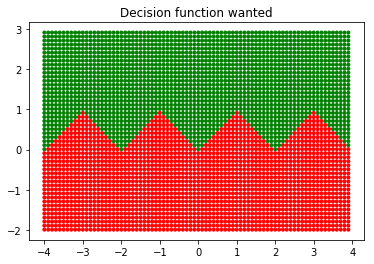

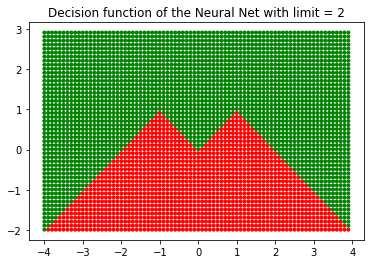

In [7]:
result_train = triangle_net.compute(input_train)
result_test = triangle_net.compute(input_test)
result_grid = triangle_net.compute(input_grid)

print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())
print("Sizes :", triangle_net.sizes)

plot2D(input_grid, output_grid, title = "Decision function wanted")
plot2D(input_grid, result_grid[0], title = "Decision function of the Neural Net with limit = " + str(limit))

# PARTIE I : Réseau random

In [8]:
name = "nets/PART1_limit" + str(limit) + ".net"

def generate_sized_net(net, delta_size):
    """Create a Decision Neural Net with inside function Relu.
    Take for sizes, the sizes of the argument net + delta_size. (only for inside layers).
    
    The net returned work therefore with the same input/output as the net given.
    """
    sizes = net.sizes.copy()
    for i in range(1, len(sizes)-1):
        sizes[i] += delta_size

    net = NeuralNet(sizes)
    for layer in net.layers[:-1]:
        layer.set_function(nd.relu)
    net.layers[-1].set_function(nd.sigmoid)
    return net

net = generate_sized_net(triangle_net, 5)



#TEST RANDOM BOF BOF
#net = NeuralNet([2,4,4,1])
#for layer in net.layers[:-1]:
#    layer.set_function(nd.relu)
#net.layers[-1].set_function(nd.sigmoid)
print("Sizes of net :", net.sizes)

Sizes of net : [2, 8, 8, 7, 1]


In [74]:
# net = NeuralNet.open(name)

In [9]:
train = net.train(input_train, output_train, epochs = 100, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.416860 , loss = 0.365925
Epochs 1: Pe = 0.385670 , loss = 0.282906
Epochs 2: Pe = 0.342220 , loss = 0.210631
Epochs 3: Pe = 0.310540 , loss = 0.170035
Epochs 4: Pe = 0.277595 , loss = 0.149538
Epochs 5: Pe = 0.185955 , loss = 0.130867
Epochs 6: Pe = 0.114685 , loss = 0.109148
Epochs 7: Pe = 0.079415 , loss = 0.085271
Epochs 8: Pe = 0.066920 , loss = 0.066475
Epochs 9: Pe = 0.058180 , loss = 0.055212
Epochs 10: Pe = 0.050590 , loss = 0.046694
Epochs 11: Pe = 0.041685 , loss = 0.039553
Epochs 12: Pe = 0.031320 , loss = 0.032361
Epochs 13: Pe = 0.023735 , loss = 0.026905
Epochs 14: Pe = 0.015715 , loss = 0.024023
Epochs 15: Pe = 0.012500 , loss = 0.022206
Epochs 16: Pe = 0.012215 , loss = 0.020728
Epochs 17: Pe = 0.010900 , loss = 0.019428
Epochs 18: Pe = 0.009600 , loss = 0.018259
Epochs 19: Pe = 0.008450 , loss = 0.017337
Epochs 20: Pe = 0.007585 , loss = 0.016431
Epochs 21: Pe = 0.006860 , loss = 0.015709
Epochs 22: Pe = 0.006780 , loss = 0.015078
Epochs 23: Pe = 0.006

% de reussite : 0.9991


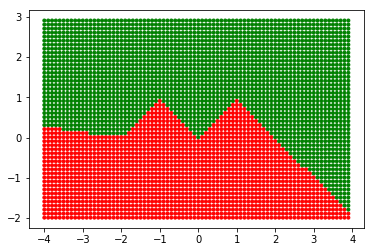

In [10]:
result_train = nd.round(net.compute(input_train))[0]
result_test = nd.round(net.compute(input_test))[0]
result_grid = nd.round(net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

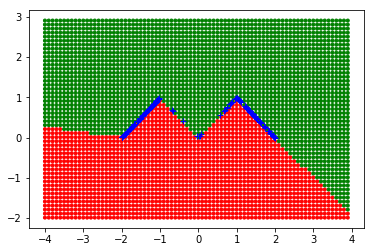

In [11]:
#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [66]:
#net.save(name)

## PARTIE II : Réseau fixé, choix de certains parametres

In [12]:
triangle_net = generate_triangle_net(limit, optimize = False)
print(triangle_net.to_string())

//NeuralNet V1.2

//Sizes :
2 2 3 2 2 2 3 2 2 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
1.0 0.0 
0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
0.0 0.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
1 1 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
0.0 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
1.0 0.0 
0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-1.0 -0.0 
-0.0 -1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-1.0 1.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.

## a)
Rotations completement libres

Biais completement libres mais initialement cohérents (égaux au signe pret) (Essais avec biais initialement libres non fonctionnels)

In [15]:
name = "nets/PART2a_limit" + str(limit) + ".net"
def generate_sym_net_2a(limit):
    n = math.ceil(math.log2(limit))
    
    layers = []
    sizes = [2]
    for i in range(n + 1): # n+ 1: fold /0 then /2**i
        # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
        layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
        sizes.append(2)
        
        # Folding Should be able to change the bias. (The bias should be the same in the 3 places, but the current NN does not allow us to do that)
        b = nd.random.normal(loc = 0, scale = 1, shape = 1)
        
        weights = nd.array([[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        bias = nd.zeros(3)
        bias[0] = b
        bias[1] = -b
        fixed = nd.array([[0, 1, 1], [0, 1, 1], [1, 1, 1]]) # all except the 2 first bias
        layers.append(Layer(3, 2, weights = weights, bias = bias, function = [nd.relu, nd.relu, nd.identity], fixed = fixed))
        sizes.append(3)
        
        weights = nd.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
        bias = nd.zeros(2)
        bias[0] = b
        fixed = nd.array([[0, 1, 1, 1], [1, 1, 1, 1]]) # All except the first bias
        layers.append(Layer(2,3, weights = weights, bias = bias, function = nd.identity, fixed = fixed))
        sizes.append(2)
        
    # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
    layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
    sizes.append(2)
    
    layers.append(Layer(1, 2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = nd.sigmoid, fixed = True))
    sizes.append(1)
    
    return NeuralNet(sizes, layers)

sym_net = generate_sym_net_2a(limit)
print(sym_net.sizes)

[2, 2, 3, 2, 2, 3, 2, 2, 1]


In [ ]:
#net = NeuralNet.open(name)

In [16]:
train = sym_net.train(input_train, output_train, epochs = 150, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.302355 , loss = 0.198719
Epochs 1: Pe = 0.278490 , loss = 0.181160
Epochs 2: Pe = 0.229415 , loss = 0.163723
Epochs 3: Pe = 0.190715 , loss = 0.146861
Epochs 4: Pe = 0.181350 , loss = 0.134092
Epochs 5: Pe = 0.172890 , loss = 0.125872
Epochs 6: Pe = 0.165200 , loss = 0.119915
Epochs 7: Pe = 0.157525 , loss = 0.115471
Epochs 8: Pe = 0.151095 , loss = 0.112207
Epochs 9: Pe = 0.145700 , loss = 0.109507
Epochs 10: Pe = 0.141145 , loss = 0.107131
Epochs 11: Pe = 0.137845 , loss = 0.105052
Epochs 12: Pe = 0.134925 , loss = 0.103207
Epochs 13: Pe = 0.132715 , loss = 0.101563
Epochs 14: Pe = 0.131035 , loss = 0.100098
Epochs 15: Pe = 0.129555 , loss = 0.098791
Epochs 16: Pe = 0.128225 , loss = 0.097635
Epochs 17: Pe = 0.127020 , loss = 0.096626
Epochs 18: Pe = 0.125900 , loss = 0.095684
Epochs 19: Pe = 0.124950 , loss = 0.094841
Epochs 20: Pe = 0.124255 , loss = 0.094118
Epochs 21: Pe = 0.123680 , loss = 0.093462
Epochs 22: Pe = 0.122990 , loss = 0.092843
Epochs 23: Pe = 0.122

% de reussite : 0.952775


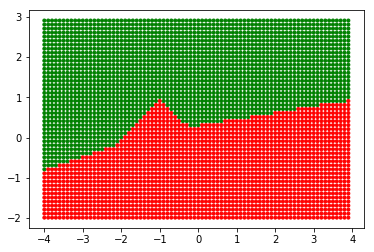

In [17]:
result_train = nd.round(sym_net.compute(input_train))[0]
result_test = nd.round(sym_net.compute(input_test))[0]
result_grid = nd.round(sym_net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

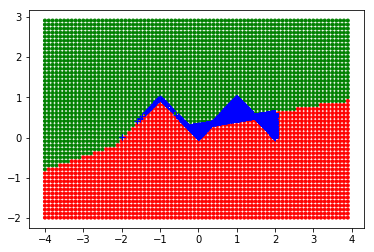

In [18]:
## PLOT ERRORS

#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [19]:
print(sym_net.to_string())

//NeuralNet V1.2

//Sizes :
2 2 3 2 2 3 2 2 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
2.2983835 -0.5462924 
0.7342272 -3.0149763 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-2.8691316 2.8306801 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
-2.4474127 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
0 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
1.779169 -1.2249293 
-2.750132 2.3681502 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
0.6047163 -0.5999695 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0 1 

//Fixed weights :
1 1 

In [ ]:
#net.save(name)

## b)
Rotations fixes

Biais libres mais initialement cohérents

Apprentissage correct pour limit = 2. Non testé pour plus. Le réseau de sortie est proche de celui de symétrie.

In [29]:
name = "nets/PART2b_limit" + str(limit) + ".net"
def generate_sym_net_2b(limit):
    n = math.ceil(math.log2(limit))
    
    layers = []
    sizes = [2]
    for i in range(n + 1): # n+ 1: fold /0 then /2**i
        # ROT fixed        
        if (i == 1):
            ROT = -nd.eye(2)
            layers.append(Layer(2, 2, weights = ROT, bias = nd.zeros(2), function = nd.identity, fixed = 1))
            sizes.append(2)
        
        
        # Folding Should be able to change the bias. (The bias should be the same in the 3 places, but the current NN does not allow us to do that)
        b = nd.random.normal(loc = 0, scale = 1, shape = 1)
        
        weights = nd.array([[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        bias = nd.zeros(3)
        bias[0] = b
        bias[1] = -b
        fixed = nd.array([[0, 1, 1], [0, 1, 1], [1, 1, 1]]) # all except the 2 first bias
        layers.append(Layer(3, 2, weights = weights, bias = bias, function = [nd.relu, nd.relu, nd.identity], fixed = fixed))
        sizes.append(3)
        
        weights = nd.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
        bias = nd.zeros(2)
        bias[0] = b
        fixed = nd.array([[0, 1, 1, 1], [1, 1, 1, 1]]) # All except the first bias
        layers.append(Layer(2,3, weights = weights, bias = bias, function = nd.identity, fixed = fixed))
        sizes.append(2)
        
    
    ROT = -nd.eye(2)
    layers.append(Layer(2, 2, weights = ROT, bias = nd.zeros(2), function = nd.identity, fixed = 1))
    sizes.append(2)
    
    layers.append(Layer(1, 2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = nd.sigmoid, fixed = True))
    sizes.append(1)
    
    return NeuralNet(sizes, layers)

sym_net = generate_sym_net_2b(limit)
print(sym_net.sizes)

[2, 3, 2, 2, 3, 2, 2, 1]


In [ ]:
#net = NeuralNet.open(name)

In [30]:
train = sym_net.train(input_train, output_train, epochs = 100, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.327500 , loss = 0.198594
Epochs 1: Pe = 0.223695 , loss = 0.182608
Epochs 2: Pe = 0.120015 , loss = 0.176214
Epochs 3: Pe = 0.068370 , loss = 0.174592
Epochs 4: Pe = 0.056355 , loss = 0.173913
Epochs 5: Pe = 0.055230 , loss = 0.173290
Epochs 6: Pe = 0.049550 , loss = 0.172795
Epochs 7: Pe = 0.042005 , loss = 0.172520
Epochs 8: Pe = 0.033130 , loss = 0.172363
Epochs 9: Pe = 0.025200 , loss = 0.172265
Epochs 10: Pe = 0.017420 , loss = 0.172215
Epochs 11: Pe = 0.013100 , loss = 0.172190
Epochs 12: Pe = 0.010355 , loss = 0.172179
Epochs 13: Pe = 0.008485 , loss = 0.172173
Epochs 14: Pe = 0.007240 , loss = 0.172168
Epochs 15: Pe = 0.007365 , loss = 0.172168
Epochs 16: Pe = 0.006575 , loss = 0.172169
Epochs 17: Pe = 0.005320 , loss = 0.172170
Epochs 18: Pe = 0.004155 , loss = 0.172170
Epochs 19: Pe = 0.007475 , loss = 0.172171
Epochs 20: Pe = 0.005815 , loss = 0.172172
Epochs 21: Pe = 0.005520 , loss = 0.172168
Epochs 22: Pe = 0.005465 , loss = 0.172168
Epochs 23: Pe = 0.004

% de reussite : 0.997955


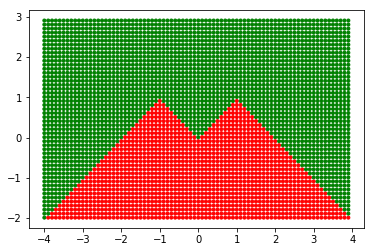

In [31]:
result_train = nd.round(sym_net.compute(input_train))[0]
result_test = nd.round(sym_net.compute(input_test))[0]
result_grid = nd.round(sym_net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

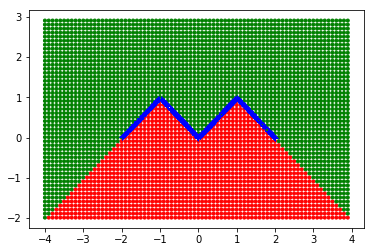

In [34]:
## PLOT ERRORS

#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [33]:
print(sym_net.to_string())

//NeuralNet V1.2

//Sizes :
2 3 2 2 3 2 2 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-0.0018684585 -0.0010212568 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
-0.3718133 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
0 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-1.0 0.0 
0.0 -1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-0.6282001 0.62694746 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
-0.9932932 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
0 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//La

In [116]:
#net.save(name)

## c)
Biais fixes

rotations complètement libres. (Pas de conditions sur les matrices)


Ok pour une limite de 2. Non fonctionel plus loin. De plus il ne trouve pas de bonnes matrices de rotations. (Ce n'est pas la solution 'attendue' mais c'est une solution particulière du problème de limite 2)

In [35]:
name = "nets/PART2c_limit" + str(limit) + ".net"
def generate_sym_net_2a(limit):
    n = math.ceil(math.log2(limit))
    
    layers = []
    sizes = [2]
    b = [0] + [2**i for i in range(n-1, -1, -1)]
    for i in range(n + 1): # n+ 1: fold /0 then /2**i
        # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
        layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
        sizes.append(2)
        
        # Folding All is fixed
        
        weights = nd.array([[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        bias = nd.zeros(3)
        bias[0] = -b[i]
        bias[1] = b[i]
        layers.append(Layer(3, 2, weights = weights, bias = bias, function = [nd.relu, nd.relu, nd.identity], fixed = True))
        sizes.append(3)
        
        weights = nd.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
        bias = nd.zeros(2)
        bias[0] = -b[i]
        layers.append(Layer(2,3, weights = weights, bias = bias, function = nd.identity, fixed = True))
        sizes.append(2)
        
    # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
    layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
    sizes.append(2)
    
    layers.append(Layer(1, 2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = nd.sigmoid, fixed = True))
    sizes.append(1)
    
    return NeuralNet(sizes, layers)

sym_net = generate_sym_net_2a(limit)
print(sym_net.sizes)

[2, 2, 3, 2, 2, 3, 2, 2, 1]


In [37]:
train = sym_net.train(input_train, output_train, epochs = 100, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.451400 , loss = 0.251196
Epochs 1: Pe = 0.384225 , loss = 0.241704
Epochs 2: Pe = 0.373765 , loss = 0.235551
Epochs 3: Pe = 0.373995 , loss = 0.228658
Epochs 4: Pe = 0.342140 , loss = 0.219097
Epochs 5: Pe = 0.282475 , loss = 0.205663
Epochs 6: Pe = 0.251825 , loss = 0.185209
Epochs 7: Pe = 0.206475 , loss = 0.159516
Epochs 8: Pe = 0.188940 , loss = 0.143983
Epochs 9: Pe = 0.192300 , loss = 0.136890
Epochs 10: Pe = 0.189010 , loss = 0.132505
Epochs 11: Pe = 0.177865 , loss = 0.126726
Epochs 12: Pe = 0.160615 , loss = 0.118472
Epochs 13: Pe = 0.132230 , loss = 0.106535
Epochs 14: Pe = 0.098620 , loss = 0.092767
Epochs 15: Pe = 0.063065 , loss = 0.081781
Epochs 16: Pe = 0.050000 , loss = 0.073143
Epochs 17: Pe = 0.048110 , loss = 0.066547
Epochs 18: Pe = 0.041035 , loss = 0.061532
Epochs 19: Pe = 0.035140 , loss = 0.057642
Epochs 20: Pe = 0.033100 , loss = 0.054473
Epochs 21: Pe = 0.030285 , loss = 0.051898
Epochs 22: Pe = 0.027775 , loss = 0.049695
Epochs 23: Pe = 0.026

% de reussite : 0.99786


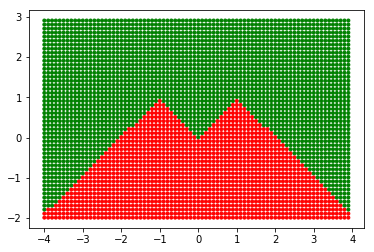

In [38]:
result_train = nd.round(sym_net.compute(input_train))[0]
result_test = nd.round(sym_net.compute(input_test))[0]
result_grid = nd.round(sym_net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

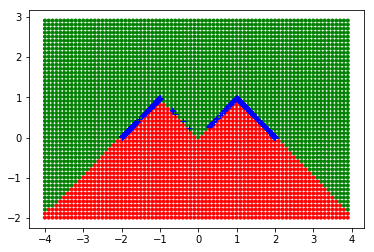

In [39]:
## PLOT ERRORS

#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [40]:
print(sym_net.to_string())

//NeuralNet V1.2

//Sizes :
2 2 3 2 2 3 2 2 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-4.1989226 0.0040603997 
-0.0020647096 -2.99446 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
0.0 0.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
1 1 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
0.0 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-0.9320929 -0.97181904 
1.8447839 3.4903822 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-1.0 1.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
1 1 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Lay

In [32]:
# net.save(name)

## PARTIE III : Réseau dédié : Partage des paramètres de symétries

## a) 
Choix completement libre

Non fonctionnel. Réduit la frontière à une droite.

In [41]:
name = "nets/PART3_limit" + str(limit) + ".net"
n = math.ceil(math.log2(limit))
net = SymNet(n + 1)
print(net.to_string())

//SymNet V1.0

//thetas :
0.33223206 0.038274862 0.27457264 

//Biases :
-0.99913603 -0.10269886 

//Thetas fixed :
0 0 0 

//Biases fixed:
0 0 


In [42]:
train = net.train(input_train, output_train, epochs = 100, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.502585 , loss = 0.380787
Epochs 1: Pe = 0.501725 , loss = 0.313244
Epochs 2: Pe = 0.396865 , loss = 0.249581
Epochs 3: Pe = 0.306005 , loss = 0.225864
Epochs 4: Pe = 0.284660 , loss = 0.213802
Epochs 5: Pe = 0.272045 , loss = 0.202537
Epochs 6: Pe = 0.253810 , loss = 0.195443
Epochs 7: Pe = 0.241845 , loss = 0.192882
Epochs 8: Pe = 0.240970 , loss = 0.192372
Epochs 9: Pe = 0.241415 , loss = 0.192388
Epochs 10: Pe = 0.241420 , loss = 0.192384
Epochs 11: Pe = 0.241080 , loss = 0.192347
Epochs 12: Pe = 0.240875 , loss = 0.192332
Epochs 13: Pe = 0.240740 , loss = 0.192324
Epochs 14: Pe = 0.240685 , loss = 0.192321
Epochs 15: Pe = 0.240625 , loss = 0.192314
Epochs 16: Pe = 0.240585 , loss = 0.192310
Epochs 17: Pe = 0.240565 , loss = 0.192304
Epochs 18: Pe = 0.240495 , loss = 0.192298
Epochs 19: Pe = 0.240435 , loss = 0.192293
Epochs 20: Pe = 0.240335 , loss = 0.192287
Epochs 21: Pe = 0.240230 , loss = 0.192280
Epochs 22: Pe = 0.240150 , loss = 0.192274
Epochs 23: Pe = 0.240

% de reussite : 0.916105


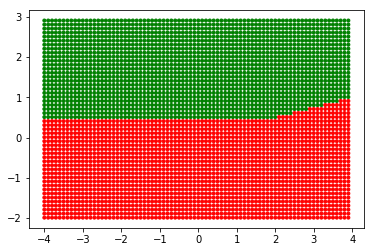

In [45]:
result_train = nd.round(net.compute(input_train))
result_test = nd.round(net.compute(input_test))
result_grid = nd.round(net.compute(input_grid))
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

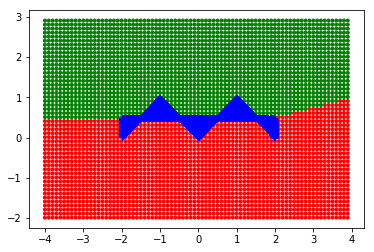

In [46]:
## PLOT ERRORS

#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [47]:
print(net.to_string())

//SymNet V1.0

//thetas :
0.1209638 -0.44973573 -0.21343763 

//Biases :
-2.0103416 -0.10269886 

//Thetas fixed :
0 0 0 

//Biases fixed:
0 0 


## b)
Symétries à angles donnés. On bloque l'apprentissage des rotations intermédiaires (Mais pas des biais)

Fonctionelle jusqu'à une limite de 16, Apprends les biais attendus !

In [48]:
name = "nets/PART3b_limit" + str(limit) + ".net"
n = math.ceil(math.log2(limit))

# theta = nd.random.normal(0,1)
# thetas = [theta] + [nd.array([0])]*(n) + [-theta]
# thetas_fixed = [0] + [1]*(n) + [0]

thetas = [nd.array([0])] * (n+2)
thetas[1] = nd.array([math.pi])
thetas[-1] = nd.array([math.pi])
net = SymNet(n + 1, thetas = thetas, thetas_fixed = True)
print(net.to_string())

//SymNet V1.0

//thetas :
0.0 3.1415927 3.1415927 

//Biases :
0.5773983 1.0265481 

//Thetas fixed :
True True True 

//Biases fixed:
0 0 


In [49]:
train = net.train(input_train, output_train, epochs = 150, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.233030 , loss = 0.206814
Epochs 1: Pe = 0.233405 , loss = 0.200705
Epochs 2: Pe = 0.223095 , loss = 0.190355
Epochs 3: Pe = 0.166530 , loss = 0.181070
Epochs 4: Pe = 0.091530 , loss = 0.174892
Epochs 5: Pe = 0.030730 , loss = 0.172509
Epochs 6: Pe = 0.008905 , loss = 0.172189
Epochs 7: Pe = 0.015385 , loss = 0.172252
Epochs 8: Pe = 0.011860 , loss = 0.172222
Epochs 9: Pe = 0.004670 , loss = 0.172180
Epochs 10: Pe = 0.004270 , loss = 0.172171
Epochs 11: Pe = 0.002875 , loss = 0.172173
Epochs 12: Pe = 0.005715 , loss = 0.172174
Epochs 13: Pe = 0.001190 , loss = 0.172172
Epochs 14: Pe = 0.003150 , loss = 0.172169
Epochs 15: Pe = 0.003780 , loss = 0.172170
Epochs 16: Pe = 0.001560 , loss = 0.172170
Epochs 17: Pe = 0.003190 , loss = 0.172170
Epochs 18: Pe = 0.001950 , loss = 0.172171
Epochs 19: Pe = 0.003320 , loss = 0.172169
Epochs 20: Pe = 0.002890 , loss = 0.172169
Epochs 21: Pe = 0.002545 , loss = 0.172169
Epochs 22: Pe = 0.004190 , loss = 0.172170
Epochs 23: Pe = 0.002

% de reussite : 0.99818


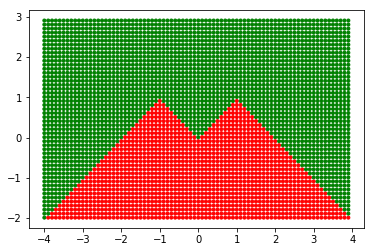

In [50]:
result_train = nd.round(net.compute(input_train))
result_test = nd.round(net.compute(input_test))
result_grid = nd.round(net.compute(input_grid))
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

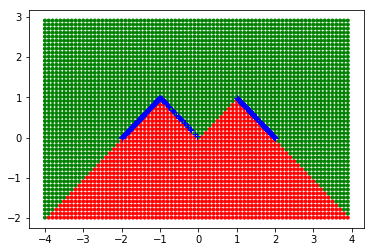

In [51]:
## PLOT ERRORS
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [52]:
print(net.to_string())

//SymNet V1.0

//thetas :
0.0 3.1415927 3.1415927 

//Biases :
-0.0010363543 0.9956273 

//Thetas fixed :
True True True 

//Biases fixed:
0 0 


In [119]:
# net.save(name)

## c
Symétries à biais donnés. On cherche les angles de rotations

Ne donne pas de bons résultats avec une limite de 2.

In [65]:
name = "nets/PART3b_limit" + str(limit) + ".net"
n = math.ceil(math.log2(limit))

biases = [nd.array([0])] + [nd.array([2**(n-1-i)]) for i in range(n)]
net = SymNet(n + 1, biases = biases, biases_fixed = True)
print(net.to_string())

//SymNet V1.0

//thetas :
-1.604436 -0.09003018 0.051240787 

//Biases :
0.0 1.0 

//Thetas fixed :
0 0 0 

//Biases fixed:
True True 


In [61]:
# net = SymNet.open(name)

In [66]:
train = net.train(input_train, output_train, epochs = 100, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.618695 , loss = 0.355904
Epochs 1: Pe = 0.606560 , loss = 0.350940
Epochs 2: Pe = 0.588290 , loss = 0.341093
Epochs 3: Pe = 0.533735 , loss = 0.330283
Epochs 4: Pe = 0.534035 , loss = 0.319422
Epochs 5: Pe = 0.498855 , loss = 0.308161
Epochs 6: Pe = 0.469850 , loss = 0.293791
Epochs 7: Pe = 0.452610 , loss = 0.274943
Epochs 8: Pe = 0.420950 , loss = 0.253314
Epochs 9: Pe = 0.375895 , loss = 0.232508
Epochs 10: Pe = 0.349295 , loss = 0.215671
Epochs 11: Pe = 0.307920 , loss = 0.204356
Epochs 12: Pe = 0.288660 , loss = 0.198338
Epochs 13: Pe = 0.277990 , loss = 0.196024
Epochs 14: Pe = 0.274730 , loss = 0.195349
Epochs 15: Pe = 0.275675 , loss = 0.195242
Epochs 16: Pe = 0.275760 , loss = 0.195252
Epochs 17: Pe = 0.275825 , loss = 0.195256
Epochs 18: Pe = 0.275580 , loss = 0.195254
Epochs 19: Pe = 0.275880 , loss = 0.195246
Epochs 20: Pe = 0.275830 , loss = 0.195262
Epochs 21: Pe = 0.275125 , loss = 0.195260
Epochs 22: Pe = 0.276160 , loss = 0.195258
Epochs 23: Pe = 0.275

% de reussite : 0.88846


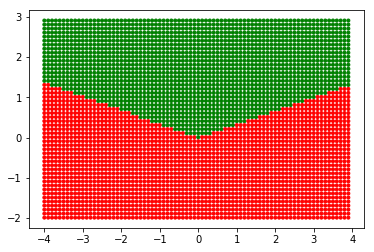

In [67]:
result_train = nd.round(net.compute(input_train))
result_test = nd.round(net.compute(input_test))
result_grid = nd.round(net.compute(input_grid))
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

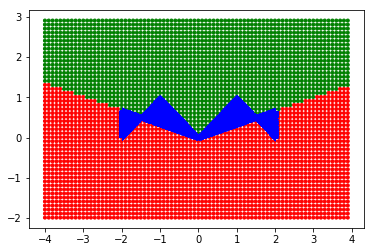

In [68]:
## PLOT ERRORS
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [69]:
print(net.to_string())

//SymNet V1.0

//thetas :
-0.0016287633 -0.3005688 -0.1592979 

//Biases :
0.0 1.0 

//Thetas fixed :
0 0 0 

//Biases fixed:
True True 


In [ ]:
# net.save(name)

# PARTIE IV : Tentative d'explications

In [42]:
net = SymNet(3)
print(net.to_string())

//SymNet V1.0

//thetas :
-0.5699138 -0.4441304 -0.42826492 0.6144514 

//Biases :
-0.15364648 -0.37117806 -0.3276384 

//Thetas fixed :
0 0 0 0 

//Biases fixed:
0 0 0 


In [51]:
# Take some time. Feel free to reduce the precision of the range.

thetas = [i/1000 for i in range(-5000, 5000,1)]
losses = []

k = 0
for theta in thetas:
    k += 1
    if k%100 == 0:
        print(k)
    net.thetas[0] = nd.array([theta])
    result_test = net.compute(input_test)
    losses.append(NeuralNet.squared_error(output_test, result_test))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [56]:
losses = [loss.asscalar() for loss in losses]

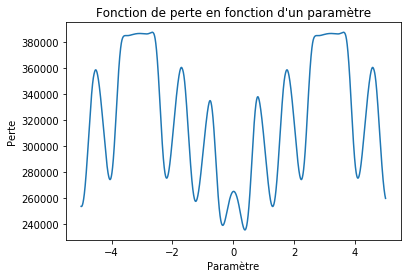

In [58]:
plt.plot(thetas, losses)
plt.title("Fonction de perte en fonction d'un paramètre")
plt.xlabel("Paramètre")
plt.ylabel("Perte")
plt.show()